# **DLAI PROJECT Team 4**



# Optional B: GAN
Steps:


1. Implement a generator and discriminator based con deconvolutions and convolutions respectively.

2. Train the GAN on MNIST.

3. Generate samples with the generator and show them.

**EXERCISE 1** Implement a generator and discriminator based con deconvolutions and convolutions respectively.

In [28]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
import random
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SOME UTILS WITH MINOR IMPORTANCE:

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()

def rand_label():
    FT = torch.cuda.LongTensor
    return Variable(FT(np.random.randint(0, 10, batch_size)))


  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    img = img.cpu().float()    
    img = (img*std+mean)*255

    image_numpy = img.detach().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

Import DATASET

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

Lets create a DataLoader for the Mnist Dataset

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

Now, lets define the GENERATOR

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(10, 10)
        self._fc = torch.nn.Linear(100, 1024*4*4)
        self.Linear = torch.nn.Linear(100*110, 100*100)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, labels3):
        x = torch.cat((self.label_embed(labels3), x), -1)
        x = x.view(-1, 100*110)
        x=self.Linear(x)
        x = x.view(100, 100)
        x = self._fc(x)        
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        x = self._conv3(x)
        return x


And now the DISCRIMINATOR

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_embed_d = nn.Embedding(10, 10)
        self.Pol = nn.MaxPool1d(1,1)

        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels2):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)

        return self._fc(x.view(-1, 512*4*4))

Lets create the MODEL

In [0]:
class Model:

    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    def generate_samples(self, batch_size):
        z = norm_noise(batch_size)
        gen_label = rand_label()
        fake_samples = self._generator(z,gen_label)
        return fake_samples, gen_label
    
    def step_optimization(self, real_samples, labels1):
        fake_samples, gen_label = self.generate_samples(real_samples.size(0))
        
        loss_g = self._step_opt_g(fake_samples, gen_label)
        
        loss_d = self._step_opt_d(real_samples, fake_samples.detach(), gen_label, labels1)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, gen_label):
        self._opt_g.zero_grad()
        estim_fake = self._discriminator(fake_samples, gen_label)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples, gen_label, labels1):
        self._opt_d.zero_grad()

        estim_real = self._discriminator(real_samples,labels1)
        loss_real = self._criterion(estim_real, self._label_real)

        estim_fake = self._discriminator(fake_samples, gen_label)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        self._opt_d.step()

        return loss_real.item(), loss_fake.item()

**EXERCISE 2** Train the GAN on MNIST.


In [0]:
num_epochs = 10
num_val_samples = 100
model = Model(batch_size)

epoch: 0/10, batch: 0/600, G_loss: 0.6928050518035889, D_loss: (0.6915773749351501, 0.6934914588928223)


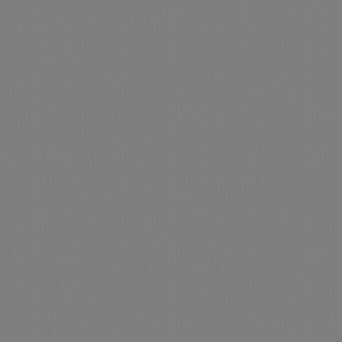

epoch: 0/10, batch: 10/600, G_loss: 0.6624794006347656, D_loss: (0.565267026424408, 0.7248241305351257)
epoch: 0/10, batch: 20/600, G_loss: 0.8569320440292358, D_loss: (0.4782422184944153, 0.5525317192077637)
epoch: 0/10, batch: 30/600, G_loss: 1.149609088897705, D_loss: (0.2996474802494049, 0.38099080324172974)
epoch: 0/10, batch: 40/600, G_loss: 1.3794264793395996, D_loss: (0.21205644309520721, 0.2902260720729828)
epoch: 0/10, batch: 50/600, G_loss: 1.7891907691955566, D_loss: (0.14283064007759094, 0.18335343897342682)
epoch: 0/10, batch: 60/600, G_loss: 2.171896457672119, D_loss: (0.10381904244422913, 0.12538209557533264)
epoch: 0/10, batch: 70/600, G_loss: 2.552443504333496, D_loss: (0.06974434852600098, 0.08193574845790863)
epoch: 0/10, batch: 80/600, G_loss: 2.893662691116333, D_loss: (0.047490790486335754, 0.05872521549463272)
epoch: 0/10, batch: 90/600, G_loss: 3.172450542449951, D_loss: (0.04131900146603584, 0.04284945875406265)
epoch: 0/10, batch: 100/600, G_loss: 3.358864068

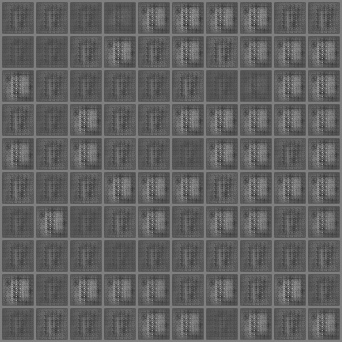

epoch: 0/10, batch: 110/600, G_loss: 3.567415475845337, D_loss: (0.029422903433442116, 0.029440956190228462)
epoch: 0/10, batch: 120/600, G_loss: 1.9721832275390625, D_loss: (0.8040890693664551, 0.3068847358226776)
epoch: 0/10, batch: 130/600, G_loss: 2.756544589996338, D_loss: (0.5977226495742798, 0.07502197474241257)
epoch: 0/10, batch: 140/600, G_loss: 0.6733703017234802, D_loss: (0.031201450154185295, 0.7703109979629517)
epoch: 0/10, batch: 150/600, G_loss: 2.8824243545532227, D_loss: (0.14280830323696136, 0.08458849787712097)
epoch: 0/10, batch: 160/600, G_loss: 3.183128595352173, D_loss: (0.335691899061203, 0.04264397919178009)
epoch: 0/10, batch: 170/600, G_loss: 2.8267297744750977, D_loss: (0.055406007915735245, 0.06403021514415741)
epoch: 0/10, batch: 180/600, G_loss: 3.579313278198242, D_loss: (0.3994022011756897, 0.03290608525276184)
epoch: 0/10, batch: 190/600, G_loss: 0.9314480423927307, D_loss: (0.07949918508529663, 0.5295312404632568)
epoch: 0/10, batch: 200/600, G_loss:

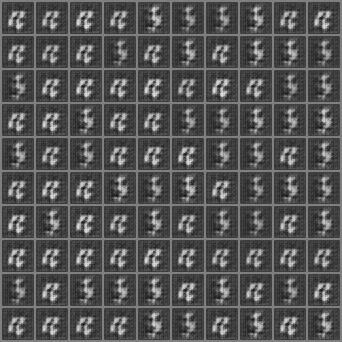

epoch: 0/10, batch: 210/600, G_loss: 0.5929974913597107, D_loss: (0.020433111116290092, 0.8152119517326355)
epoch: 0/10, batch: 220/600, G_loss: 0.5876761674880981, D_loss: (0.04773835092782974, 0.8481578826904297)
epoch: 0/10, batch: 230/600, G_loss: 2.535262107849121, D_loss: (0.47856491804122925, 0.08514679968357086)
epoch: 0/10, batch: 240/600, G_loss: 1.9598039388656616, D_loss: (0.08969603478908539, 0.17458252608776093)
epoch: 0/10, batch: 250/600, G_loss: 2.772958755493164, D_loss: (0.17044515907764435, 0.06605880707502365)
epoch: 0/10, batch: 260/600, G_loss: 2.197909355163574, D_loss: (0.05460061505436897, 0.16138657927513123)
epoch: 0/10, batch: 270/600, G_loss: 2.093104600906372, D_loss: (0.22252438962459564, 0.14307476580142975)
epoch: 0/10, batch: 280/600, G_loss: 1.2145389318466187, D_loss: (0.05126244202256203, 0.3633710443973541)
epoch: 0/10, batch: 290/600, G_loss: 2.06107234954834, D_loss: (0.06267958879470825, 0.14155304431915283)
epoch: 0/10, batch: 300/600, G_loss:

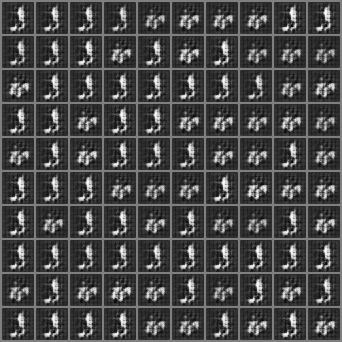

epoch: 0/10, batch: 310/600, G_loss: 2.1051344871520996, D_loss: (0.15134328603744507, 0.13574834167957306)
epoch: 0/10, batch: 320/600, G_loss: 2.0273499488830566, D_loss: (0.12131296843290329, 0.14543664455413818)
epoch: 0/10, batch: 330/600, G_loss: 1.7716279029846191, D_loss: (0.04272822290658951, 0.1869809925556183)
epoch: 0/10, batch: 340/600, G_loss: 1.761641025543213, D_loss: (0.14508134126663208, 0.19076724350452423)
epoch: 0/10, batch: 350/600, G_loss: 1.211442232131958, D_loss: (0.02413986623287201, 0.35974356532096863)
epoch: 0/10, batch: 360/600, G_loss: 2.2490668296813965, D_loss: (0.2095463126897812, 0.11542169749736786)
epoch: 0/10, batch: 370/600, G_loss: 2.592146396636963, D_loss: (0.2214435338973999, 0.08554472029209137)
epoch: 0/10, batch: 380/600, G_loss: 1.7507911920547485, D_loss: (0.10231001675128937, 0.20378009974956512)
epoch: 0/10, batch: 390/600, G_loss: 2.817000389099121, D_loss: (0.11294832825660706, 0.06307035684585571)
epoch: 0/10, batch: 400/600, G_loss

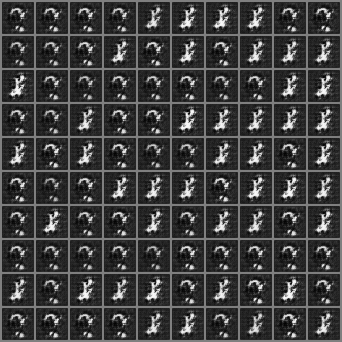

epoch: 0/10, batch: 410/600, G_loss: 1.5649513006210327, D_loss: (0.026619572192430496, 0.8073387742042542)
epoch: 0/10, batch: 420/600, G_loss: 2.685589551925659, D_loss: (0.21350881457328796, 0.07118229568004608)
epoch: 0/10, batch: 430/600, G_loss: 2.119901418685913, D_loss: (0.01776466891169548, 0.1286635398864746)
epoch: 0/10, batch: 440/600, G_loss: 1.737289309501648, D_loss: (0.15470601618289948, 0.19425366818904877)
epoch: 0/10, batch: 450/600, G_loss: 2.978670597076416, D_loss: (0.08508794009685516, 0.05261412262916565)
epoch: 0/10, batch: 460/600, G_loss: 3.2007524967193604, D_loss: (0.01879769004881382, 0.08848945796489716)
epoch: 0/10, batch: 470/600, G_loss: 2.39268159866333, D_loss: (0.08204317837953568, 0.09749796241521835)
epoch: 0/10, batch: 480/600, G_loss: 4.025742053985596, D_loss: (0.08730936795473099, 0.019653266295790672)
epoch: 0/10, batch: 490/600, G_loss: 1.8266505002975464, D_loss: (0.04854074865579605, 0.22879457473754883)
epoch: 0/10, batch: 500/600, G_loss

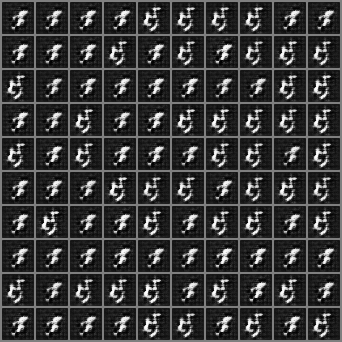

epoch: 0/10, batch: 510/600, G_loss: 1.5757699012756348, D_loss: (0.030405964702367783, 0.2487388551235199)
epoch: 0/10, batch: 520/600, G_loss: 0.162117138504982, D_loss: (0.004173727706074715, 2.179903745651245)
epoch: 0/10, batch: 530/600, G_loss: 2.0758252143859863, D_loss: (0.11356448382139206, 0.13534480333328247)
epoch: 0/10, batch: 540/600, G_loss: 1.9804120063781738, D_loss: (0.10003577917814255, 0.1494160294532776)
epoch: 0/10, batch: 550/600, G_loss: 2.9159936904907227, D_loss: (0.45973488688468933, 0.05759050324559212)
epoch: 0/10, batch: 560/600, G_loss: 2.025848150253296, D_loss: (0.10528580844402313, 0.1483086198568344)
epoch: 0/10, batch: 570/600, G_loss: 2.1265318393707275, D_loss: (0.0772416889667511, 0.34329113364219666)
epoch: 0/10, batch: 580/600, G_loss: 2.0615897178649902, D_loss: (0.2734434902667999, 0.13812120258808136)
epoch: 0/10, batch: 590/600, G_loss: 3.1006524562835693, D_loss: (0.28836068511009216, 0.1954949051141739)
epoch: 1/10, batch: 0/600, G_loss: 2

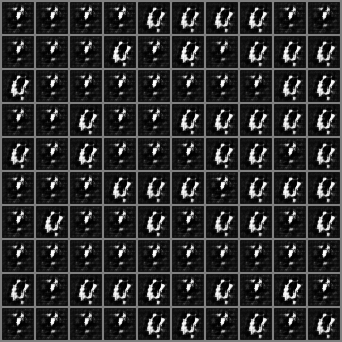

epoch: 1/10, batch: 10/600, G_loss: 2.0383901596069336, D_loss: (0.12803252041339874, 0.14045214653015137)
epoch: 1/10, batch: 20/600, G_loss: 3.75819730758667, D_loss: (0.16536672413349152, 0.03328002989292145)
epoch: 1/10, batch: 30/600, G_loss: 3.6232428550720215, D_loss: (0.10196518898010254, 0.027244828641414642)
epoch: 1/10, batch: 40/600, G_loss: 2.1159636974334717, D_loss: (0.09416761249303818, 0.1301618069410324)
epoch: 1/10, batch: 50/600, G_loss: 2.4199516773223877, D_loss: (0.2586572766304016, 0.10141624510288239)
epoch: 1/10, batch: 60/600, G_loss: 2.751711845397949, D_loss: (0.10095876455307007, 0.09566844254732132)
epoch: 1/10, batch: 70/600, G_loss: 2.3868672847747803, D_loss: (0.2648348808288574, 0.10194601118564606)
epoch: 1/10, batch: 80/600, G_loss: 2.941126823425293, D_loss: (0.2054063081741333, 0.0569630041718483)
epoch: 1/10, batch: 90/600, G_loss: 4.1458659172058105, D_loss: (0.7283405065536499, 0.01629592292010784)
epoch: 1/10, batch: 100/600, G_loss: 2.9603579

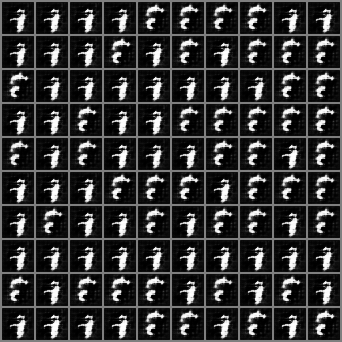

epoch: 1/10, batch: 110/600, G_loss: 2.1339519023895264, D_loss: (0.21999341249465942, 0.1298508495092392)
epoch: 1/10, batch: 120/600, G_loss: 5.6234259605407715, D_loss: (0.5745947360992432, 0.005680065602064133)
epoch: 1/10, batch: 130/600, G_loss: 4.250536918640137, D_loss: (0.5044815540313721, 0.018288562074303627)
epoch: 1/10, batch: 140/600, G_loss: 2.793104887008667, D_loss: (0.19639916718006134, 0.06500449776649475)
epoch: 1/10, batch: 150/600, G_loss: 4.430090427398682, D_loss: (0.11865536868572235, 0.024587877094745636)
epoch: 1/10, batch: 160/600, G_loss: 3.063403606414795, D_loss: (0.14863279461860657, 0.04808274284005165)
epoch: 1/10, batch: 170/600, G_loss: 2.286743402481079, D_loss: (0.07482659071683884, 0.1305721402168274)
epoch: 1/10, batch: 180/600, G_loss: 1.6475523710250854, D_loss: (0.190792515873909, 0.24552612006664276)
epoch: 1/10, batch: 190/600, G_loss: 2.0674047470092773, D_loss: (0.1250361204147339, 0.1386837214231491)
epoch: 1/10, batch: 200/600, G_loss: 2

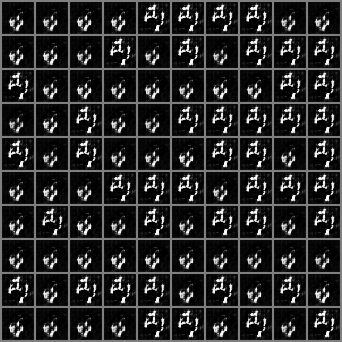

epoch: 1/10, batch: 210/600, G_loss: 2.028435230255127, D_loss: (0.19743438065052032, 0.1514163464307785)
epoch: 1/10, batch: 220/600, G_loss: 2.4337990283966064, D_loss: (0.09746506065130234, 0.09300234168767929)
epoch: 1/10, batch: 230/600, G_loss: 3.6916720867156982, D_loss: (0.3408515453338623, 0.02989707514643669)
epoch: 1/10, batch: 240/600, G_loss: 4.115619659423828, D_loss: (0.20065076649188995, 0.0694613829255104)
epoch: 1/10, batch: 250/600, G_loss: 2.342012405395508, D_loss: (0.14799503982067108, 0.10143496841192245)
epoch: 1/10, batch: 260/600, G_loss: 2.8111536502838135, D_loss: (0.11975156515836716, 0.062450483441352844)
epoch: 1/10, batch: 270/600, G_loss: 8.429162979125977, D_loss: (1.8694658279418945, 0.0006281297537498176)
epoch: 1/10, batch: 280/600, G_loss: 1.8957592248916626, D_loss: (0.08638698607683182, 0.1629919558763504)
epoch: 1/10, batch: 290/600, G_loss: 4.510720729827881, D_loss: (0.11944403499364853, 0.013705167919397354)
epoch: 1/10, batch: 300/600, G_los

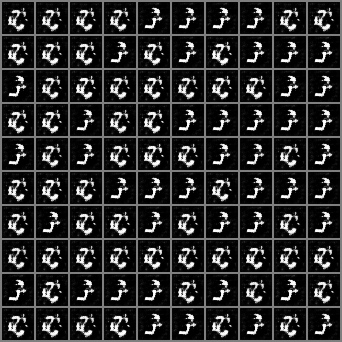

epoch: 1/10, batch: 310/600, G_loss: 3.2375478744506836, D_loss: (0.07763608545064926, 0.0590272918343544)
epoch: 1/10, batch: 320/600, G_loss: 5.396948337554932, D_loss: (0.44897329807281494, 0.005521425046026707)
epoch: 1/10, batch: 330/600, G_loss: 1.9598710536956787, D_loss: (0.12477356195449829, 0.17106470465660095)
epoch: 1/10, batch: 340/600, G_loss: 3.0168373584747314, D_loss: (0.10090275853872299, 0.05077777057886124)
epoch: 1/10, batch: 350/600, G_loss: 2.709141731262207, D_loss: (0.238393172621727, 0.0715593695640564)
epoch: 1/10, batch: 360/600, G_loss: 3.1473188400268555, D_loss: (0.16324512660503387, 0.045601364225149155)
epoch: 1/10, batch: 370/600, G_loss: 2.145139694213867, D_loss: (0.06286142021417618, 0.1281730979681015)
epoch: 1/10, batch: 380/600, G_loss: 2.6140758991241455, D_loss: (0.06883115321397781, 0.07613615691661835)
epoch: 1/10, batch: 390/600, G_loss: 2.651047706604004, D_loss: (0.08363442122936249, 0.0762459933757782)
epoch: 1/10, batch: 400/600, G_loss:

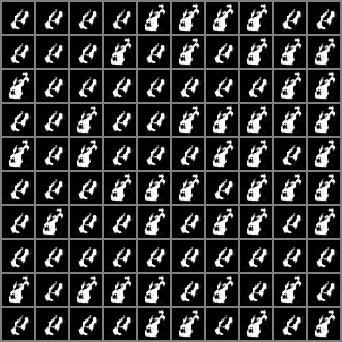

epoch: 1/10, batch: 410/600, G_loss: 4.8647356033325195, D_loss: (0.41489875316619873, 0.008112027309834957)
epoch: 1/10, batch: 420/600, G_loss: 2.9062345027923584, D_loss: (0.060508422553539276, 0.05627831816673279)
epoch: 1/10, batch: 430/600, G_loss: 2.6296441555023193, D_loss: (0.10160885006189346, 0.08267419785261154)
epoch: 1/10, batch: 440/600, G_loss: 4.106103897094727, D_loss: (0.02222793735563755, 0.04219941794872284)
epoch: 1/10, batch: 450/600, G_loss: 6.789063930511475, D_loss: (0.805930495262146, 0.001147402566857636)
epoch: 1/10, batch: 460/600, G_loss: 2.344099283218384, D_loss: (0.1928364783525467, 0.15784259140491486)
epoch: 1/10, batch: 470/600, G_loss: 3.1174933910369873, D_loss: (0.16678637266159058, 0.06532271951436996)
epoch: 1/10, batch: 480/600, G_loss: 4.049096584320068, D_loss: (0.1256849318742752, 0.03911520540714264)
epoch: 1/10, batch: 490/600, G_loss: 2.127047538757324, D_loss: (0.08128693699836731, 0.13396959006786346)
epoch: 1/10, batch: 500/600, G_los

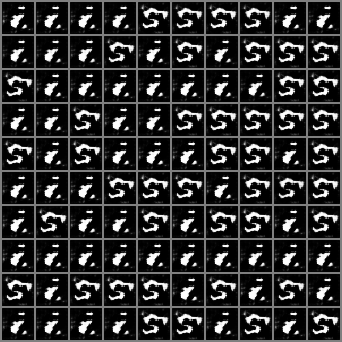

epoch: 1/10, batch: 510/600, G_loss: 3.2925989627838135, D_loss: (0.1372685581445694, 0.0383269228041172)
epoch: 1/10, batch: 520/600, G_loss: 10.800167083740234, D_loss: (3.12576961517334, 4.802456169272773e-05)
epoch: 1/10, batch: 530/600, G_loss: 1.8709955215454102, D_loss: (0.09864404797554016, 0.1690993756055832)
epoch: 1/10, batch: 540/600, G_loss: 3.802227735519409, D_loss: (0.20983995497226715, 0.04961015656590462)
epoch: 1/10, batch: 550/600, G_loss: 2.708103656768799, D_loss: (0.17408668994903564, 0.07611269503831863)
epoch: 1/10, batch: 560/600, G_loss: 3.0782837867736816, D_loss: (0.12905572354793549, 0.04762028530240059)
epoch: 1/10, batch: 570/600, G_loss: 3.6023354530334473, D_loss: (0.061420511454343796, 0.028793171048164368)
epoch: 1/10, batch: 580/600, G_loss: 2.3356120586395264, D_loss: (0.0708903819322586, 0.1056247428059578)
epoch: 1/10, batch: 590/600, G_loss: 4.390868186950684, D_loss: (0.07545270025730133, 0.012710418552160263)
epoch: 2/10, batch: 0/600, G_loss:

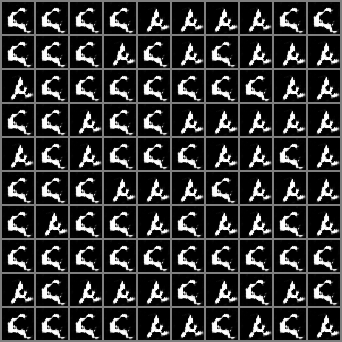

epoch: 2/10, batch: 10/600, G_loss: 2.35739803314209, D_loss: (0.08612915128469467, 0.09963560849428177)
epoch: 2/10, batch: 20/600, G_loss: 6.08232307434082, D_loss: (0.18825457990169525, 0.0049991668201982975)
epoch: 2/10, batch: 30/600, G_loss: 3.5563039779663086, D_loss: (0.030835185199975967, 0.17350375652313232)
epoch: 2/10, batch: 40/600, G_loss: 3.8400800228118896, D_loss: (0.05566360428929329, 0.02391200140118599)
epoch: 2/10, batch: 50/600, G_loss: 4.523621559143066, D_loss: (0.03710523992776871, 0.02051062136888504)
epoch: 2/10, batch: 60/600, G_loss: 2.4947783946990967, D_loss: (0.049870505928993225, 0.09437396377325058)
epoch: 2/10, batch: 70/600, G_loss: 4.1148576736450195, D_loss: (0.037045661360025406, 0.01714586466550827)
epoch: 2/10, batch: 80/600, G_loss: 3.487529993057251, D_loss: (0.044219907373189926, 0.03254799544811249)
epoch: 2/10, batch: 90/600, G_loss: 2.4821512699127197, D_loss: (0.05456487089395523, 0.08811075240373611)
epoch: 2/10, batch: 100/600, G_loss: 

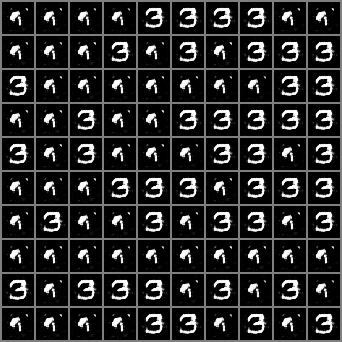

epoch: 2/10, batch: 110/600, G_loss: 6.124639511108398, D_loss: (0.04116366431117058, 0.0033052293583750725)
epoch: 2/10, batch: 120/600, G_loss: 7.427960395812988, D_loss: (0.9727804064750671, 0.0011223801411688328)
epoch: 2/10, batch: 130/600, G_loss: 1.8481085300445557, D_loss: (0.11468610912561417, 0.18173013627529144)
epoch: 2/10, batch: 140/600, G_loss: 2.8816049098968506, D_loss: (0.03033052757382393, 0.06537536531686783)
epoch: 2/10, batch: 150/600, G_loss: 3.832211971282959, D_loss: (0.13729128241539001, 0.06304845958948135)
epoch: 2/10, batch: 160/600, G_loss: 2.118245840072632, D_loss: (0.028046980500221252, 0.1325184404850006)
epoch: 2/10, batch: 170/600, G_loss: 2.7439310550689697, D_loss: (0.03485134243965149, 0.1471184492111206)
epoch: 2/10, batch: 180/600, G_loss: 3.700887680053711, D_loss: (0.15226492285728455, 0.02627956122159958)
epoch: 2/10, batch: 190/600, G_loss: 2.6044397354125977, D_loss: (0.19142471253871918, 0.08759298175573349)
epoch: 2/10, batch: 200/600, G_

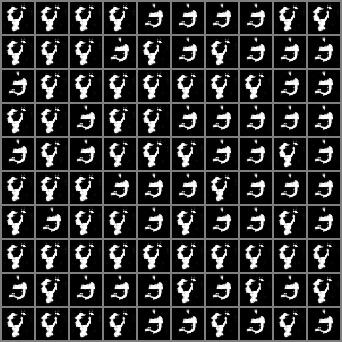

epoch: 2/10, batch: 210/600, G_loss: 2.7093679904937744, D_loss: (0.06578926742076874, 0.08565512299537659)
epoch: 2/10, batch: 220/600, G_loss: 8.209049224853516, D_loss: (0.08844107389450073, 0.0005137579282745719)
epoch: 2/10, batch: 230/600, G_loss: 3.549654483795166, D_loss: (0.11400416493415833, 0.031030042096972466)
epoch: 2/10, batch: 240/600, G_loss: 3.41267466545105, D_loss: (0.186826691031456, 0.03500918298959732)
epoch: 2/10, batch: 250/600, G_loss: 4.223982334136963, D_loss: (0.035697851330041885, 0.015485953539609909)
epoch: 2/10, batch: 260/600, G_loss: 2.9370627403259277, D_loss: (0.04896363243460655, 0.08901520818471909)
epoch: 2/10, batch: 270/600, G_loss: 3.2278854846954346, D_loss: (0.04190481826663017, 0.04057373106479645)
epoch: 2/10, batch: 280/600, G_loss: 5.236201286315918, D_loss: (0.0564136803150177, 0.005991220474243164)
epoch: 2/10, batch: 290/600, G_loss: 2.952152729034424, D_loss: (0.08210320770740509, 0.05633274465799332)
epoch: 2/10, batch: 300/600, G_l

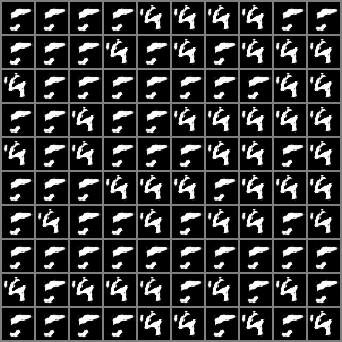

epoch: 2/10, batch: 310/600, G_loss: 3.2855842113494873, D_loss: (0.05175556614995003, 0.03990708291530609)
epoch: 2/10, batch: 320/600, G_loss: 3.6261823177337646, D_loss: (0.04654456675052643, 0.05036069080233574)
epoch: 2/10, batch: 330/600, G_loss: 12.968526840209961, D_loss: (2.3600213527679443, 3.088582161581144e-05)
epoch: 2/10, batch: 340/600, G_loss: 1.9632374048233032, D_loss: (0.09175869822502136, 0.17214584350585938)
epoch: 2/10, batch: 350/600, G_loss: 5.1016154289245605, D_loss: (0.011224490590393543, 0.047401756048202515)
epoch: 2/10, batch: 360/600, G_loss: 2.6900196075439453, D_loss: (0.04402657598257065, 0.08418414741754532)


In [0]:
for epoch in range(num_epochs):
    for n_batch, (real_samples, labels) in enumerate(data_loader):
        
        real_samples = Variable(real_samples).cuda()
        labels1 = Variable(labels).cuda()

        loss_g, loss_d = model.step_optimization(real_samples, labels1)
        
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        if (n_batch) % 100 == 0:
            val_fake_samples,_ = model.generate_samples(num_val_samples)
            display_batch_images(val_fake_samples)